In [1]:
import scipy.special as ssp
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from pylab import *
import random as rnd

from statsmodels.tsa.arima_process import ArmaProcess

In [2]:
Zt = lambda p, zt, n: np.array(
    [0 if i > 2 * p else (zt if i < p else -zt) for i in (rnd.random() for i in range(n))])  # szum dyskretny

Prosty estymator autokowariancji: $\hat{\gamma}(h)=\frac{1}{n}\displaystyle{\sum_{i=1}^{n-h}{\left(X_t-\overline{X}\right)\left(X_{t+h}-\overline{X}\right)}}, \quad h\in\mathbb{N}$

In [3]:
autocov = lambda X, lag: [
    1 / len(X) * (np.sum((np.array(X[:len(X) - i]) - np.mean(X)) * (np.array(X[i:]) - np.mean(X)))) for i in
    range(lag[0], lag[1] + 1)]  # zwykła autokowariancja

Prosty estymator autokorelacji: $\hat{\rho}=\frac{\hat{\gamma}(h)}{\hat{\gamma}(0)}, \quad h\in\mathbb{N}$

In [4]:
autocorr = lambda X, lag: [i / autocov(X, [0, 1])[0] for i in autocov(X, lag)]  # zwykła autokorelacja

<center>Estymatory robustowe ACF</center>

Statystyka $Q$.
$Q_n(x)=\kappa\times\{|x_j-x_k|; j<k\}_{(\tau)}$

In [5]:
def Q(X, k):
    values = [abs(X[j] - X[i]) for i in range(len(X)) for j in range(i)]
    values = sorted(values)
    return k * values[int(np.floor((ssp.binom(len(X), 2) + 2) / 4))]

$\hat{\gamma}_{Q_N}(h)=\frac{1}{4}\left[Q_{N-h}^2(\mathbb{u} + \mathbb{v}) - Q_{N-h}^2{(\mathbb{u}-\mathbb{v}})\right]$, gdzie wektory $u$ i $v$ to odpowiednio początkowe $N-h$ i końcowe $N-h$ wartości wektora $X$.

In [6]:
def autocov1(X, lag, k):
    acvf = []
    for h in range(lag[0], lag[1] + 1):
        if h == 0:
            u = np.array(X)
        else:
            u = np.array(X[:-h])
        v = np.array(X[h:])
        acvf.append(1 / 4 * ((Q(u + v, k)) ** 2 - (Q(u - v, k)) ** 2))
    return acvf

$\hat{\rho}_{Q_N}=\frac{Q_{N-h}^2(\mathbb{u} + \mathbb{v}) - Q_{N-h}^2{(\mathbb{u}-\mathbb{v}})}{Q_{N-h}^2(\mathbb{u} + \mathbb{v}) + Q_{N-h}^2{(\mathbb{u}-\mathbb{v}})}$

In [7]:
def autocorr1(X, lag, k):
    acf = []
    for h in range(lag[0], lag[1] + 1):
        if h == 0:
            u = np.array(X)
        else:
            u = np.array(X[:-h])
        v = np.array(X[h:])
        acf.append(((Q(u + v, k)) ** 2 - (Q(u - v, k)) ** 2) / ((Q(u + v, k)) ** 2 + (Q(u - v, k)) ** 2))
    return acf

## Szacowanie na podstawie przekształceń jednowymiarowych
$\hat{\gamma}_{Q_n}=\frac{1}{\sum_{t=1}^{n-h}{L_t^{(\alpha)}L_{t+h}^{(\alpha)}}}\left\{\displaystyle{\sum_{t=1}^{n-h}}\left(X_t-\overline{X}^{(\alpha)}\right)\left(X_{t+h}-\overline{X}^{(\alpha)}\right)L_t^{(\alpha)}L_{t+h}^{(\alpha)}\right\}$, gdzie:
$\overline{X}^{(\alpha)}=\frac{1}{\sum_{t=1}^nL_t^{(\alpha)}}\displaystyle{\sum_{t=1}^n{X_tL_t^{(\alpha)}}}$
$L_t^{(\alpha)}=\begin{cases}
1,\quad & X_{(g)} < X_t < X_{(n-g+1)} \\
0, \quad & \text{poza tym}
\end{cases}{}$
$g=\lfloor{\alpha\cdot n\rfloor},\quad\text{dla } 0\leq\alpha\leq0.5$

In [8]:
g = lambda alfa, n: int(floor(n * alfa))

In [9]:
def L(X, t, alfa):
    Y = sorted(X)
    n = len(X)
    _g = g(alfa, n)
    if Y[_g] < X[t] and X[t] < Y[n - _g]:
        return 1
    return 0

In [10]:
def mean_X(X, alfa):
    suma1 = sum([L(X, i, alfa) for i in range(len(X))])
    suma2 = sum([X[i] * L(X, i, alfa) for i in range(len(X))])
    return 1 / suma1 * suma2

In [11]:
def autocov2(X, lag, alfa):
    n = len(X)
    L_vector = [L(X, i, alfa) for i in range(n)]
    acvf = []
    for h in range(lag[0], lag[1] + 1):
        if h == 0:
            suma1 = sum(L_vector)
            suma2 = sum(np.array(X) ** 2 * np.array(L_vector))
        else:
            suma1 = sum(np.array(L_vector[:-h]) * np.array(L_vector[h:]))
            suma2 = sum(np.array(X[:-h] - mean_X(X, alfa)) * np.array(X[h:] - mean_X(X, alfa)) * np.array(
                L_vector[:-h]) * np.array(L_vector[h:]))
        acvf.append(suma2 / suma1)
    return acvf

In [12]:
def autocorr2(X, lag, alfa):
    acvf = autocov2(X, lag, alfa)[0]
    return [i / acvf for i in autocov2(X, lag, alfa)]

## Estymator oparty na scentralizowanym szeregu czasowym
## (nie wiem czy dobrze rozumiem)
$\hat{\rho}(h)=\frac{\text{med}{\left(\tilde{X_i}\tilde{X}_{1+h},\dots, \tilde{X}_{n-h}\tilde{X_n}\right)}}{\text{med}{\left(\tilde{X_1^2},\dots, \tilde{X_n^2}\right)}}$

In [13]:
def autocorr4(X, lag):
    X = np.array(X) - mean(X)
    acf = [1.0]
    denominator = np.median([i**2 for i in X])
    for h in range(lag[0] + 1, lag[1] + 1):
        acf.append(np.median(np.array(X[:-h]) * np.array(X[h:]))/denominator)
    return acf

## Szacowanie na podstawie znaków i rang
$\hat{\rho}(h)=c\displaystyle{\sum_{i=1}^{n-h}J\left(\frac{R_i}{n+1}\right)\cdot J\left(\frac{R_{i+h}}{n+1}\right)},\quad$ gdzie
$c=\frac{1}{\sum_{i=1}^nJ\left(\frac{R_i}{n+1}\right)^2}$,
$J(x) = \Phi^{-1}(x), x\in(0, 1)$
## (nie wychodzi)

In [14]:
def J(x):
    return ss.norm.ppf(x)

In [15]:
def c(X):
    n = len(X)
    R = sorted(X)
    return 1 / np.sum([(J((list(X).index(R[i]) + 1) / (n + 1)))**2 for i in range(n)])

In [16]:
def autocorr3(X, lag):
    acf = []
    n = len(X)
    R = sorted(X)
    for h in range(lag[0], lag[1] + 1):
        suma = 0
        for i in range(n-h):
            a = list(X).index(R[i])
            b = list(X).index(R[i + h])
            suma += J((R.index(list(X)[i]) + 1)/ (n+1)) * J((R.index(list(X)[i + h]) + 1)/ (n+1))
        acf.append(c(X) * suma)
    return acf

## Estymatory oparty na znakach
$\hat{\rho}(h)=\frac{1}{(n-h)(n-h-1)}\displaystyle{\sum_{i>j}\text{sign}((X_i-X_j)(X_{i+h}-X_{j+h}))}$

In [17]:
def autocorr5(X, lag):
    n = len(X)
    return [1/((n - h)*(n - h - 1)) * np.sum([np.sign((X[i] - X[j]) * (X[i + h] - X[j + h]))
                for i in range(n - h) for j in range(i)]) for h in range(lag[0], lag[1] + 1)]

$\hat{\rho}(h)=\frac{1}{n-h}\displaystyle{\sum_{i=1}^{n-h}\text{sign}((X_i-\hat\mu)(X_{i+h} - \hat\mu))}$

gdzie $\hat\mu$ to mediana szeregu $X$

In [18]:
def autocorr6(X, lag):
    n = len(X)
    mediana = np.median(X)
    acf = [1/(n - h) * np.sum(np.sign((np.array(X[:-h]) - mediana) *
    (np.array(X[h:]) - mediana))) for h in range(lag[0] + 1, lag[1] + 1)]
    return [1, *acf]

# Estymator na podstawie PACF
\begin{equation}\hat\pi(h)=2\frac{\displaystyle{\sum_{t-1}^{n-h}W_{h, t}\left(X_t-\hat X_t\right)\left(X_{t+h}-\hat X_{t+h}\right)}}{\displaystyle{\sum_{t=1}^{n-h}W_{h, t}\left[\left(X_t-\hat X_t\right)^2+\left(X_{t+h} - \hat X_{t+h}\right)^2\right]}}\end{equation}


\begin{equation}W_{h, t}=w\left(\frac{d_{ht}(b)}{s^2_{ht}}\right)\end{equation}

\begin{equation}w(x)=\frac{3}{1+x}\end{equation}

\begin{equation}d_{ht}(b)=U^2_{ht}+V^2_{ht}-2bU_{ht}V_{ht}\end{equation}

\begin{equation}U_{h, t}=X_t-\hat X_t\end{equation}

\begin{equation}\hat X_{t}=\pi_{h-1, 0} + \displaystyle{\sum_{i=1}^{h-1}\pi_{h-1, i}X_{t-i}}\end{equation}

\begin{equation}\begin{cases}
\pi(1) = \rho(1) \\
\rho(h)=\displaystyle{\sum_{i=1}^{h-1}\pi_{h-1,i}\rho(h-i)} + \pi(h)\left(1-\displaystyle{\sum_{i=1}^{h-1}\pi_{h-1, i}\rho(i)}\right)
\end{cases}
\end{equation}


\begin{equation}\begin{pmatrix}
\pi_{h, 1} \\
\vdots \\
\pi_{h, h-1}
\end{pmatrix} = \begin{pmatrix}
\pi_{h-1, 1} \\
\vdots \\
\pi_{h-1, h-1}
\end{pmatrix} -
\pi(h)\begin{pmatrix}
\pi_{h-1, h-1}\\
\vdots\\
\pi_{h-1, 1}
\end{pmatrix}\end{equation}

# Estymacja na podstawie korelacji wielowymiarowej

\begin{equation}\hat\rho(h)=\frac{1}{k-h+1}\displaystyle{\sum_{i=1}^{k-h+1}\hat\Xi^{(k)}_{i, i+h}}\end{equation}

\begin{equation}
\Xi_{i, j}^{(k)}=\frac{\Gamma_{i, j}^{(k)}}{\sqrt{\Gamma_{i, i}^{(k)}\cdot\Gamma_{j, j}^{(k)}}}
\end{equation}

\begin{equation}
\Gamma^{(k)}=\frac{Z_k'Z_k}{n}
\end{equation}

\begin{equation}
Z'_k = \begin{bmatrix}
\tilde X_1 & \tilde X_2 & \hdots & \hdots & \tilde X_{k+1} & \tilde X_n & 0 & \hdots & 0 \\
0 & \tilde X_1 & \hdots & \tilde X_k & \hdots &\tilde X_{n-1} & \tilde X_n & \ddots & \vdots \\
\vdots & \ddots & \ddots & \vdots & & \vdots & \vdots & \ddots & 0 \\
0 & \hdots & 0 & \tilde X_1 & \hdots &\tilde X_{n-k} & \tilde X_{n-k+1} & \hdots & \tilde X_n
\end{bmatrix}\in\mathbb{R}^{(k+1)\times(n+k)}
\end{equation}

\begin{equation}
\tilde X_t=X_t - \overline{X}
\end{equation}

In [19]:
def zmatrix(X, k):
    return np.matrix([[*[0 for i in range(j)], *[X[i] for i in range(k)], *[0 for i in range(k - j)]] for j in range(k+1)])

In [20]:
def gamma_k(X, k):
    z_matr = zmatrix(X, k)
    return (z_matr * z_matr.transpose())/len(X)

In [21]:
def Xi(X, k, i, j):
    gamm = gamma_k(X, k)
    return gamm[i - 1, j - 1]/np.sqrt(gamm[i - 1, i - 1] * gamm[j - 1, j - 1])

In [22]:
def autocorr7(X, lag):
    k = lag[1]
    return [1/(k - h + 1)*sum([Xi(X, k, i, i + h) for i in range(1, k - h + 2)]) for h in range(lag[0], lag[1] + 1)]

## Estymator oparty na wariancjach:
$\rho(h)=\frac{\text{Var}(X_{t+h}+X_t) - \text{Var}(X_{t+h}-X_t)}{\text{Var}(X_{t+h}+X_t) + \text{Var}(X_{t+h}-X_t)}$

In [23]:
def autocorr8(X, lag):
    X = np.array(X)
    return [(np.var(X+X) - np.var(X - X))/(np.var(X+X) + np.var(X - X)) if h == 0 else
            (np.var(X[h:]+X[:-h]) - np.var(X[h:] - X[:-h]))/(np.var(X[h:]+X[:-h]) + np.var(X[h:] - X[:-h]))
            for h in range(lag[0], lag[1] + 1)]

## Inna wersja estymatora opartego na wariancjach
### Wariancję zastępujemy jednym z dwóch poniższych estymatorów (podnosząc do kwadratu)
### $\text{MAD}=1.4826\cdot\text{med}\{|x_i-x_{\text{med}}|;i=1,\dots,n\}$
### $\text{IQR}=0.7413\cdot(Q_3-Q_1)$

In [24]:
def MAD2(X, const=1.4826):
    return (const * np.median([abs(i - np.median(X)) for i in X]))**2

def IQR2(X, const=0.7413):
    return (const * (np.quantile(X, 0.75) - np.quantile(X, 0.25)))**2

In [25]:
def autocorr9(X, lag):
    X = np.array(X)
    return [(MAD2(X+X) - MAD2(X - X))/(MAD2(X+X) + MAD2(X - X)) if h == 0 else
            (MAD2(X[h:]+X[:-h]) - MAD2(X[h:] - X[:-h]))/(MAD2(X[h:]+X[:-h]) + MAD2(X[h:] - X[:-h]))
            for h in range(lag[0], lag[1] + 1)]

def autocorr10(X, lag):
    X = np.array(X)
    return [(IQR2(X+X) - IQR2(X - X))/(IQR2(X+X) + IQR2(X - X)) if h == 0 else
            (IQR2(X[h:]+X[:-h]) - IQR2(X[h:] - X[:-h]))/(IQR2(X[h:]+X[:-h]) + IQR2(X[h:] - X[:-h]))
            for h in range(lag[0], lag[1] + 1)]

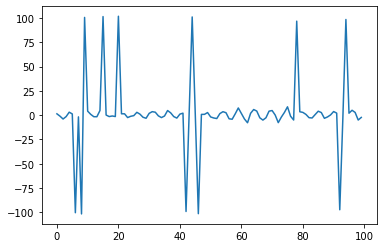

In [26]:
ar4 = np.array([1, 0.33, 0.5, 0.86, 0.34])
ma4 = np.array([1, 0.9, 0.3, 0.12, 0.94])
Y = ArmaProcess(ar4, ma4).generate_sample(nsample=100) + Zt(0.03, 100, 100)
plt.plot(Y)

Wykresy

In [27]:
def comparison(robust_acf_estimator, discrete_noise, *args):
    ar4 = np.array([1, 0.33, 0.5, 0.86, 0.34])
    ma4 = np.array([1, 0.9, 0.3, 0.12, 0.94])
    Y = ArmaProcess(ar4, ma4).generate_sample(nsample=100)
    if discrete_noise:
        Y = np.array(Y) + Zt(0.03, 100, 100)
    simple_acf = autocorr(Y, [0, 20])
    if args:
        robust_acf = robust_acf_estimator(Y, [0, 20], *args)
    else:
        robust_acf = robust_acf_estimator(Y, [0, 20])
    fig = plt.figure(figsize=(20, 8))
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax2 = plt.subplot2grid((2, 2), (1, 0))
    ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
    for i in range(len(simple_acf)):
        ax1.plot([i, i], [0, simple_acf[i]], 'g')
        ax1.scatter(i, simple_acf[i], c='green')
        ax2.plot([i, i], [0, robust_acf[i]], 'r')
        ax2.scatter(i, robust_acf[i], c='red')
        ax3.plot([i, i], [0, simple_acf[i]], 'g')
        ax3.plot([i, i], [0, robust_acf[i]], 'r')
        ax3.scatter(i, robust_acf[i], c='red')
        ax3.scatter(i, simple_acf[i], c='green')
    ax1.set_title("Zwykły ACF")
    ax2.set_title("Robustowy ACF")
    ax3.set_title("Porównanie")
    ax3.legend(("Zwykły", "Robustowy"))
    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)
    fig.tight_layout()

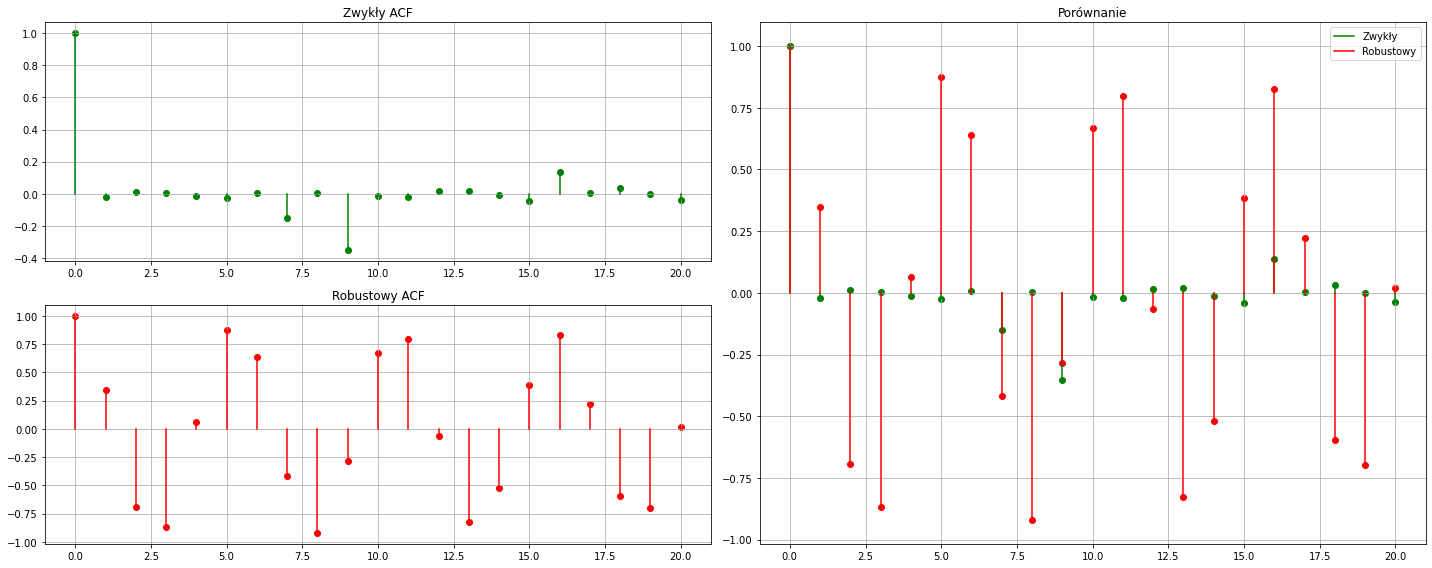

In [28]:
# zwykły acf wywala się dla dużego P

comparison(autocorr1, True, 2.2191)

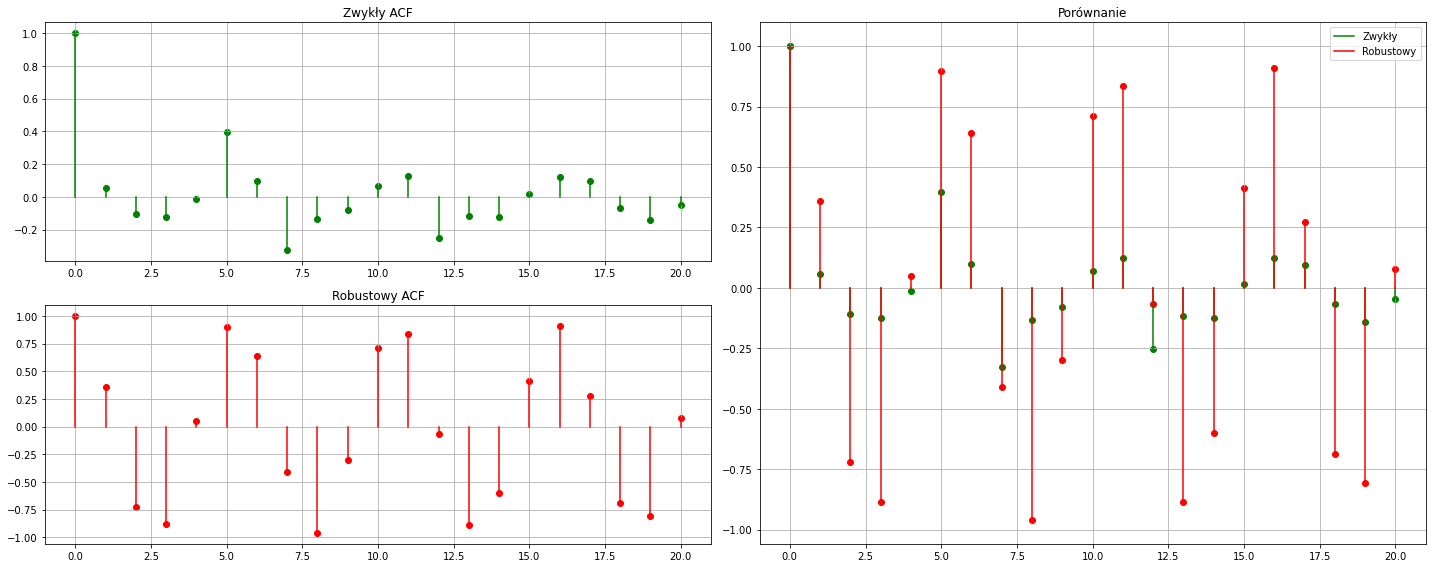

In [29]:
comparison(autocorr2, True, 0.015)

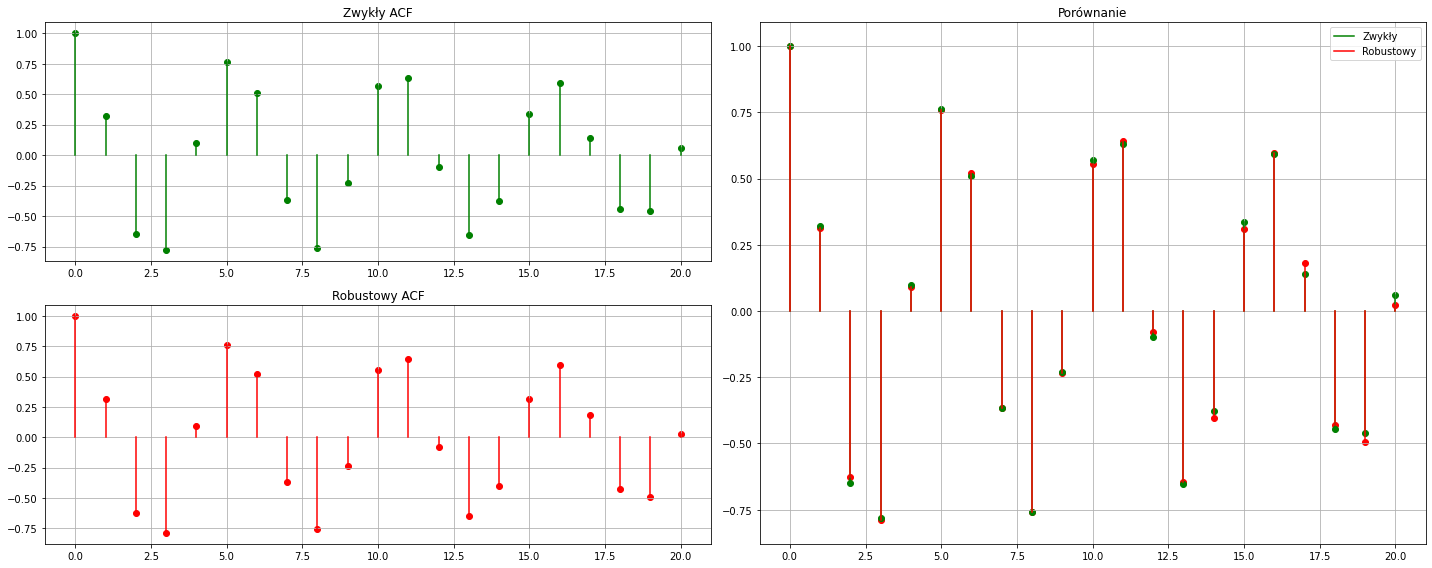

In [30]:
comparison(autocorr3, False)

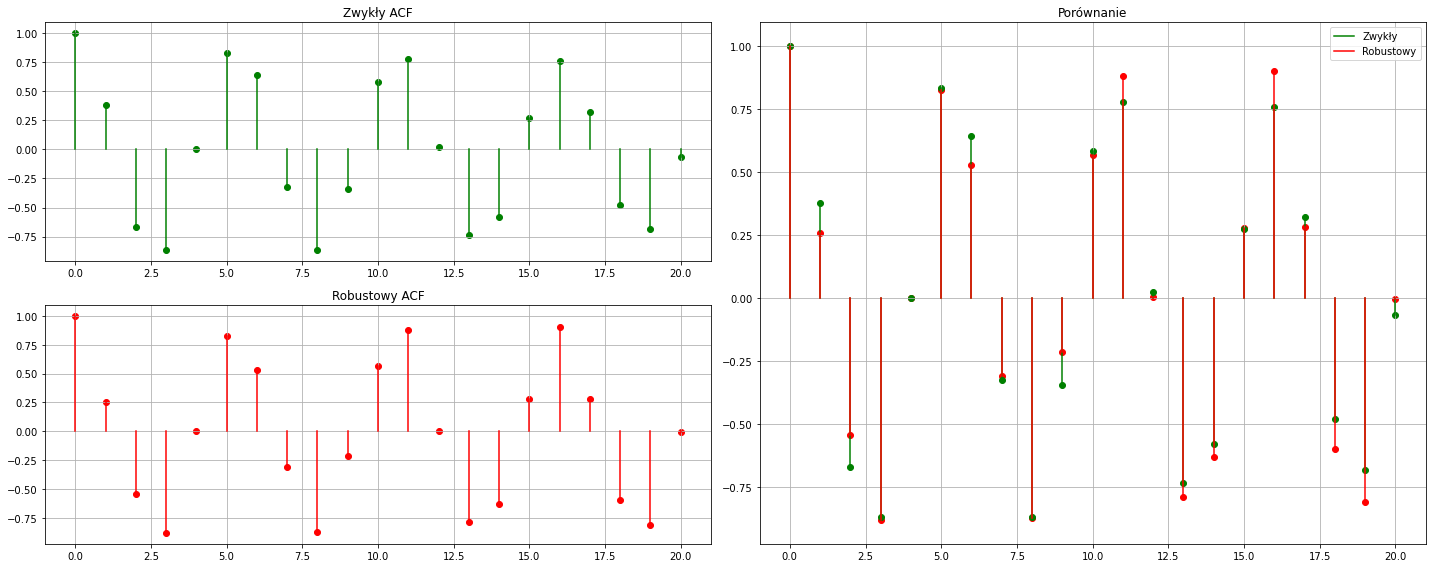

In [38]:
comparison(autocorr4, False)

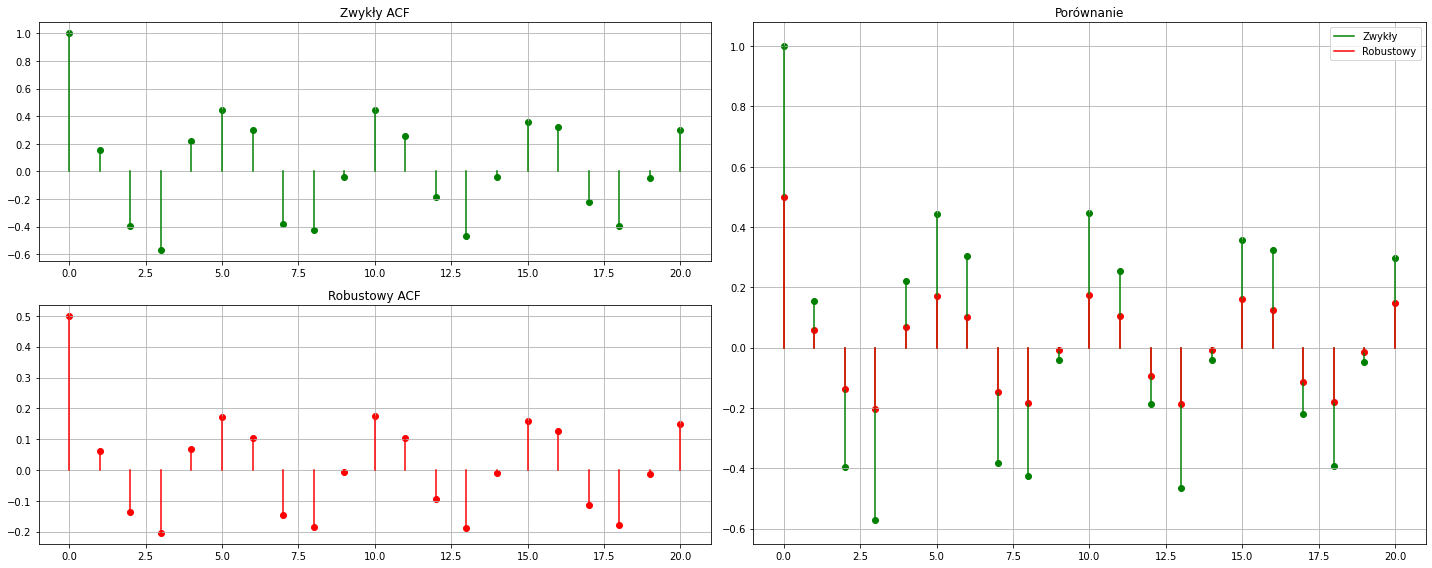

In [32]:
comparison(autocorr5, False)

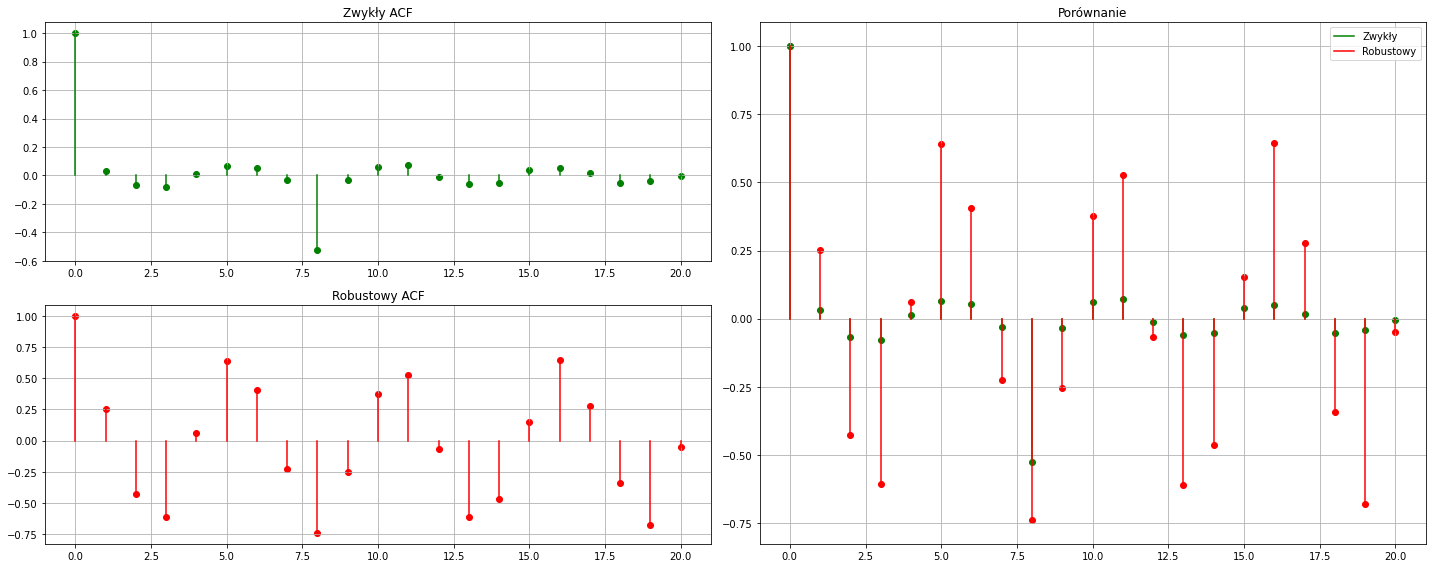

In [33]:
comparison(autocorr6, True)

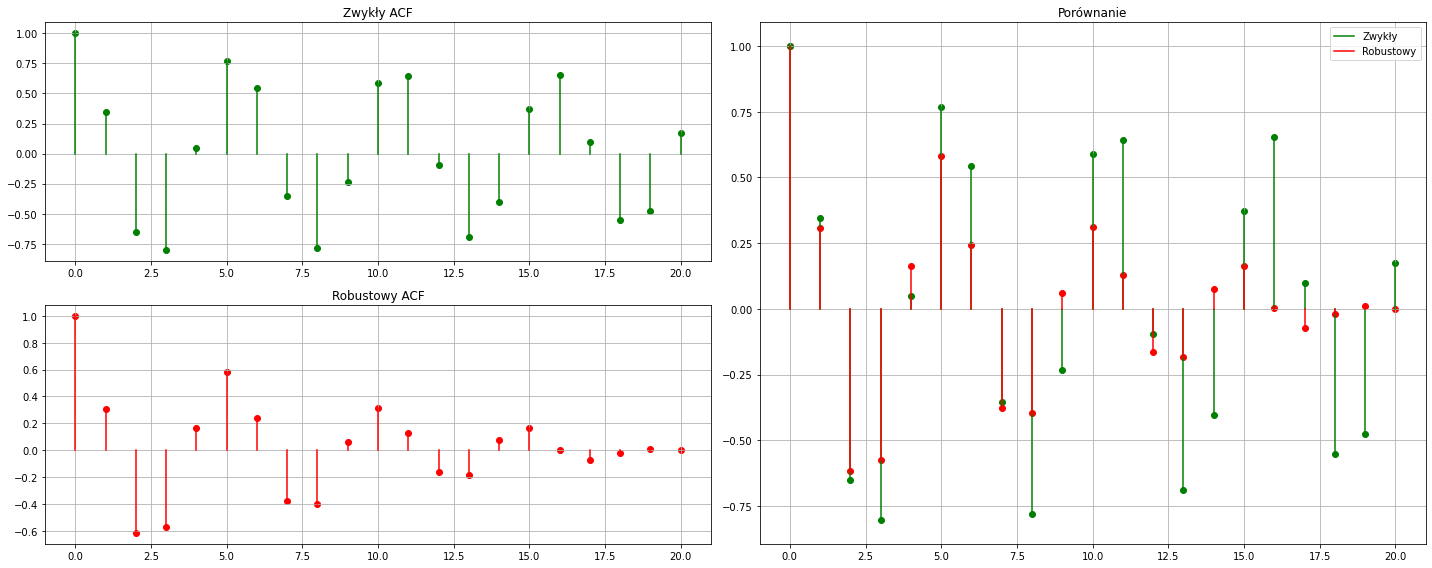

In [39]:
comparison(autocorr7, False)

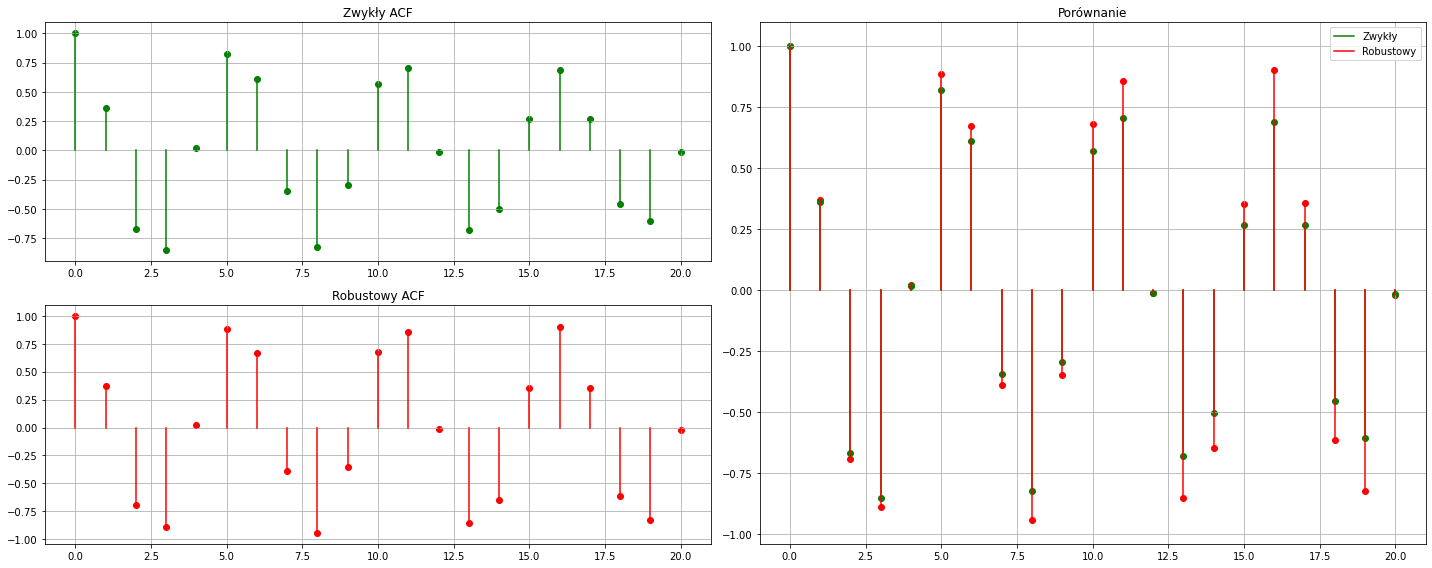

In [35]:
comparison(autocorr8, False)

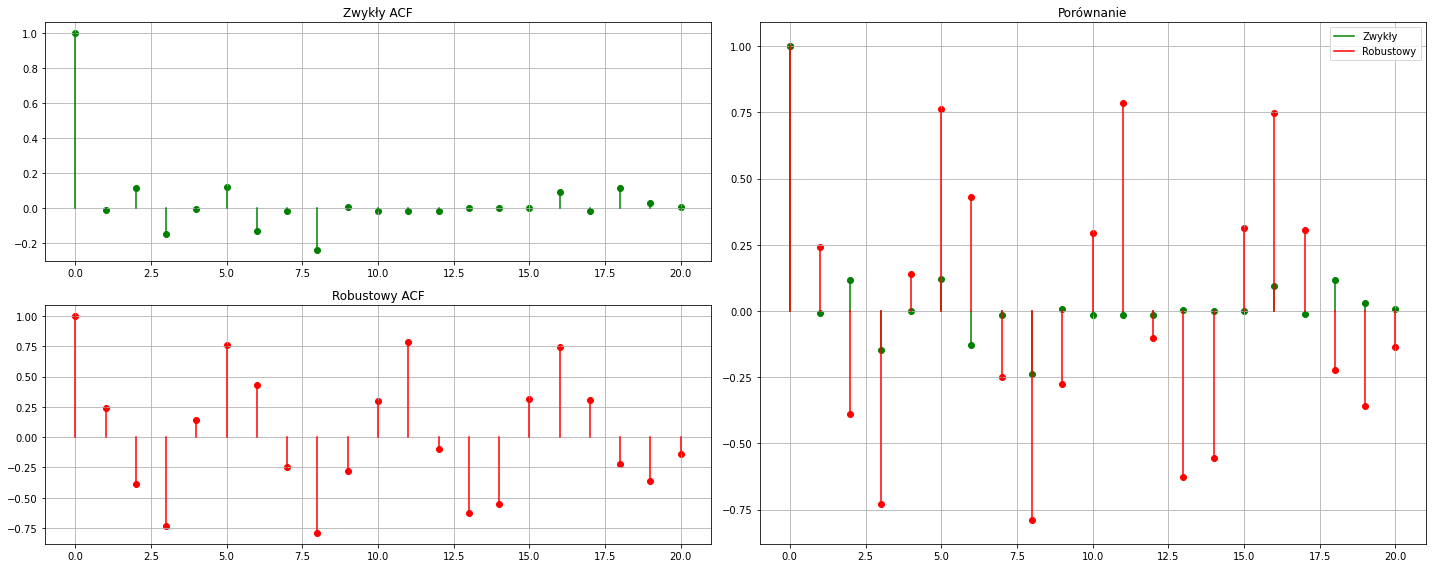

In [36]:
comparison(autocorr9, True)

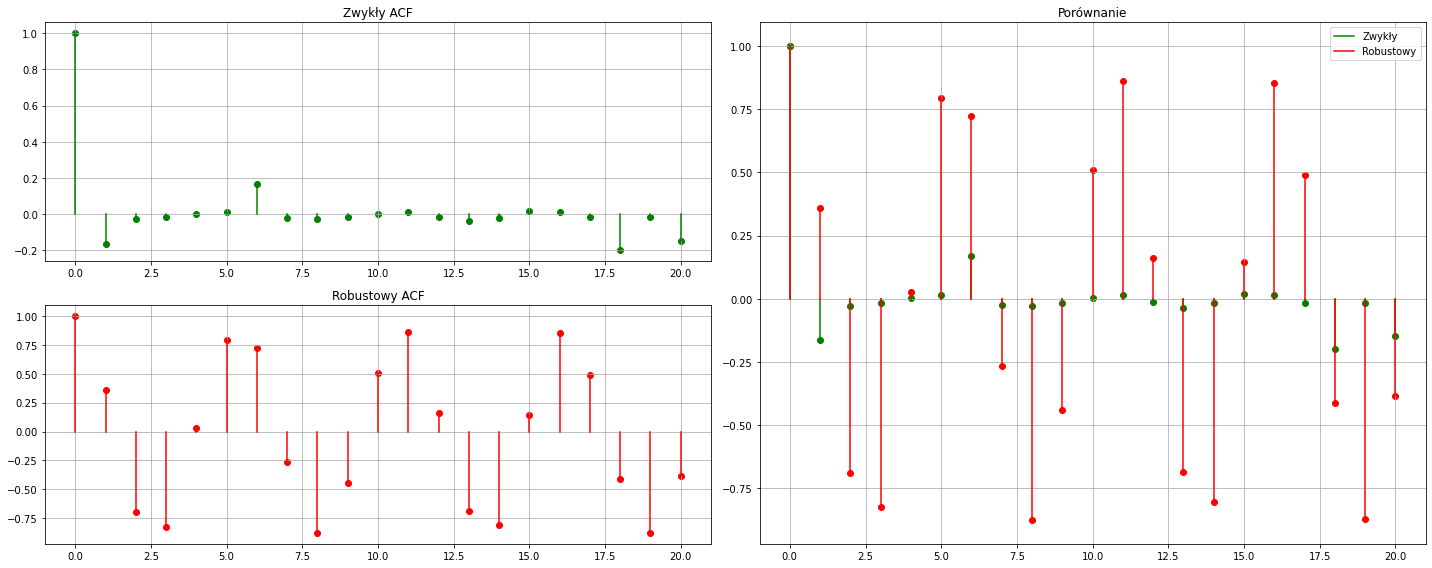

In [37]:
comparison(autocorr10, True)